<a href="https://colab.research.google.com/github/ykato27/Learning-To-Count-Everything/blob/main/Learning_To_Count_Everything_GoogleColab_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 指定物体カウントのサンプルコード

#### 環境設定

In [1]:
!git clone https://github.com/cvlab-stonybrook/LearningToCountEverything
%cd LearningToCountEverything
!wget https://raw.githubusercontent.com/Kazuhito00/models/master/research/object_detection/utils/colab_utils.py -P ./
!pip install imread-from-url >> /dev/null

Cloning into 'LearningToCountEverything'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 93 (delta 30), reused 42 (delta 27), pack-reused 43
Unpacking objects: 100% (93/93), done.
/content/LearningToCountEverything
--2021-12-02 04:42:45--  https://raw.githubusercontent.com/Kazuhito00/models/master/research/object_detection/utils/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19491 (19K) [text/plain]
Saving to: ‘./colab_utils.py’

colab_utils.py      100%[===================>]  19.03K  --.-KB/s    in 0s      

2021-12-02 04:42:45 (81.6 MB/s) - ‘./colab_utils.py’ saved [19491/19491]



#### 画像読込み

In [2]:
# 画像読み込み
import cv2
from imread_from_url import imread_from_url

image_list = []
cv_image = imread_from_url("https://pakutaso.cdn.rabify.me/shared/img/thumb/bitcoin111199PAR55252.jpg.webp?d=1420")

# 画像リストへ追加
image_list.append(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))

#### カウント対象指定

In [3]:
# カウント対象指定
import colab_utils

bboxes = []
colab_utils.annotate(image_list, box_storage_pointer=bboxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

#### LearningToCountEverything指定形式へ変更

In [4]:
# LearningToCountEverything指定形式へ変更
import numpy as np

bbox_list = []
image_width, image_height = cv_image.shape[1], cv_image.shape[0]
for bbox in bboxes[0]:
    y1 = int(bbox[0] * image_height)
    x1 = int(bbox[1] * image_width)
    y2 = int(bbox[2] * image_height)
    x2 = int(bbox[3] * image_width)

    bbox_list.append([y1, x1, y2, x2])
print(bbox_list)

[[624, 745, 899, 1017]]


### LearningToCountEverything実行


In [5]:
# CPU/GPU実行指定
import os
import torch

gpu_id = 0

if not torch.cuda.is_available() or gpu_id < 0:
    print("CPU MODE")
    use_gpu = False
else:
    print("GPU MODE")
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

GPU MODE


In [6]:
# モデルロード
from model import CountRegressor, Resnet50FPN

regressor_model_path = "./data/pretrainedModels/FamNet_Save1.pth"

resnet_50_fpn = Resnet50FPN()
count_regressor = CountRegressor(6, pool='mean')  # pool=['mean', 'max']

if use_gpu:
    resnet_50_fpn.cuda()
    count_regressor.cuda()
    count_regressor.load_state_dict(torch.load(regressor_model_path))
else:
    count_regressor.load_state_dict(torch.load(regressor_model_path, map_location=torch.device('cpu')))

resnet_50_fpn.eval()
count_regressor.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

CountRegressor(
  (regressor): Sequential(
    (0): Conv2d(6, 196, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (3): Conv2d(196, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (9): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (10): ReLU()
    (11): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (12): ReLU()
  )
)

In [7]:
# 画像、バウンディングボックス前処理
from PIL import Image
from utils import Transform

image = Image.fromarray(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
sample = {'image': image, 'lines_boxes': bbox_list}
sample = Transform(sample)
image, boxes = sample['image'], sample['boxes']

if use_gpu:
    image = image.cuda()
    boxes = boxes.cuda()

In [8]:
# 画像特徴量抽出
from utils import MAPS, Scales, extract_features

with torch.no_grad():
    features = extract_features(
        resnet_50_fpn, 
        image.unsqueeze(0), 
        boxes.unsqueeze(0), 
        MAPS, 
        Scales,
    )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [9]:
# LearningToCountEverything推論(TTA無し)
with torch.no_grad():
    output = count_regressor(features)
    np_output = output.to('cpu').detach().numpy().copy()
    np_output = np.squeeze(np_output)

In [10]:
# 結果画像保存
from utils import visualize_output_and_save

visualize_output_and_save(
    image.detach().cpu(), 
    output.detach().cpu(), 
    boxes.cpu(), 
    'result.png',
)

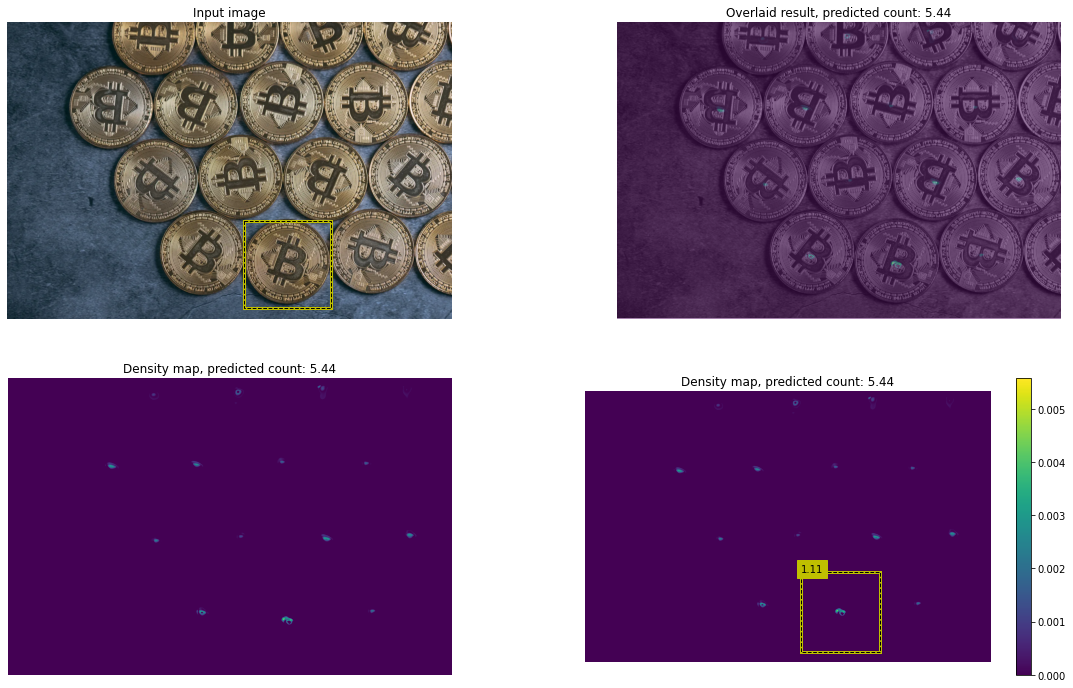

In [11]:
from google.colab.patches import cv2_imshow

result_image = cv2.imread('result.png')
cv2_imshow(result_image)

In [12]:
# LearningToCountEverything推論(TTA有り)
import copy
from tqdm import tqdm
import torch.optim as optim

from utils import MincountLoss, PerturbationLoss

# 学習パラメータ
learning_rate = 1e-7
gradient_steps = 100
weight_mincount = 1e-9
weight_perturbation = 1e-4

# adapted_regressor準備
features.required_grad = True
adapted_regressor = copy.deepcopy(count_regressor)
adapted_regressor.train()
optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)

pbar = tqdm(range(gradient_steps))
for step in pbar:
    optimizer.zero_grad()

    output = adapted_regressor(features)
    lCount = weight_mincount * MincountLoss(output, boxes, use_gpu=use_gpu)
    lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8, use_gpu=use_gpu)
    Loss = lCount + lPerturbation

    # 損失が0値のTesnorでは無い場合、損失が0になることがある
    # 0以外の場合にのみ最急降下法を実行
    if torch.is_tensor(Loss):
        Loss.backward()
        optimizer.step()

    pbar.set_description('Adaptation step: {:<3}, loss: {}, predicted-count: {:6.1f}'.format(step, Loss.item(), output.sum().item()))

features.required_grad = False
output = adapted_regressor(features)

Adaptation step: 99 , loss: 2.249776753782129e-12, predicted-count:    5.0: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


In [13]:
# 結果画像保存
from utils import visualize_output_and_save

visualize_output_and_save(
    image.detach().cpu(), 
    output.detach().cpu(), 
    boxes.cpu(), 
    'result_tta.png',
)

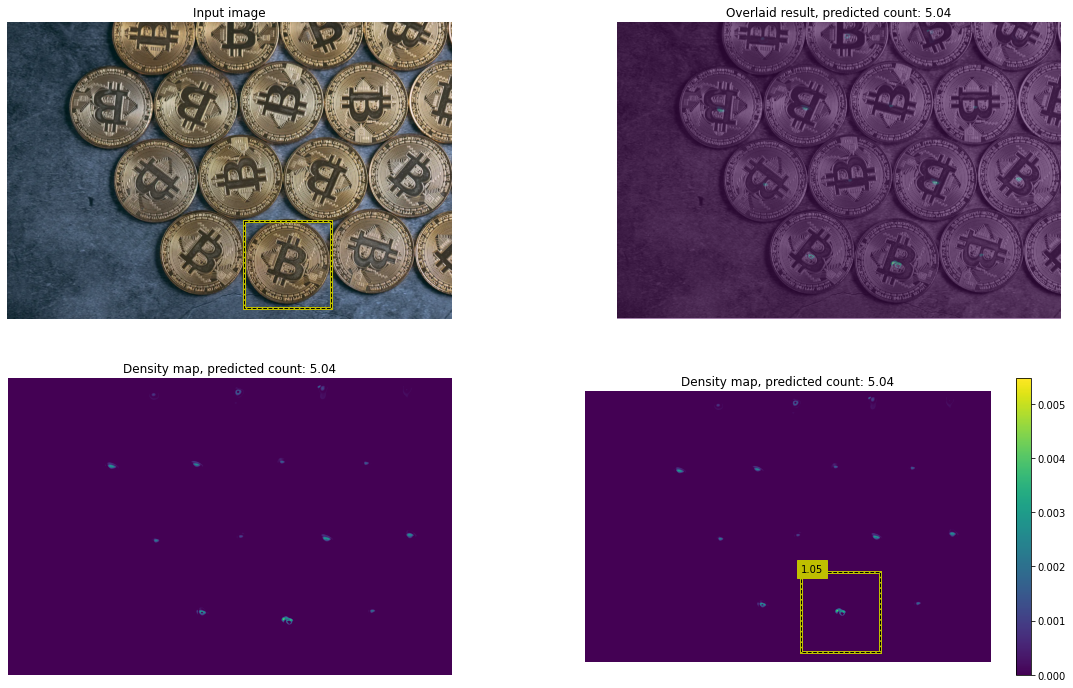

In [14]:
from google.colab.patches import cv2_imshow

result_image = cv2.imread('result_tta.png')
cv2_imshow(result_image)